In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score,ConfusionMatrixDisplay


os.environ['TF_FORCE_UNIFIED_MEMORY']='1'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='2.0'
#os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH ']='true' # as I understood, this is redundant with the set_memory_growth part :)

import tensorflow as tf    
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      print(gpu)
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Embedding, GRU, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import keras.backend as K
from keras.optimizers import Adam

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from keras.models import load_model
from keras.utils import to_categorical
from numpy import dstack



import pickle
from gensim.models import Word2Vec

def load_files(directory):
    file_list = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".c"):
                file_path = os.path.join(root, file)
                with open(file_path, "r") as file_content:
                    file_text = file_content.read()
                file_list.append(file_text)
    return file_list
# Load training and test files for vulnerable and non-vulnerable classes
def load_data():
    dataset_dir = 'F://Development_//Deep Learning//Basic Dataset//BTP//1//Dataset//Raw//dataset 1//Dataset_raw'
    vulnerable_dir = os.path.join(dataset_dir, 'Vulnerable')
    non_vulnerable_dir = os.path.join(dataset_dir, 'Non_vulnerable')

    vulnerable_train_files = load_files(os.path.join(vulnerable_dir, 'TRAIN'))
    vulnerable_test_files = load_files(os.path.join(vulnerable_dir, 'TEST'))
    non_vulnerable_train_files = load_files(os.path.join(non_vulnerable_dir, 'TRAIN'))
    non_vulnerable_test_files = load_files(os.path.join(non_vulnerable_dir, 'TEST'))

    train_codes = vulnerable_train_files + non_vulnerable_train_files
    test_codes = vulnerable_test_files + non_vulnerable_test_files

    # train_codes = train_codes+ test_codes

    labels = np.concatenate((np.ones(len(vulnerable_train_files)), np.zeros(len(non_vulnerable_train_files))), axis=0)

    X_train, X_test, y_train, y_test = train_test_split(train_codes, labels, test_size=0.3, random_state=42)

    # Print lengths of all datasets
    print("Length of X_train:", len(X_train))
    print("Length of X_test:", len(X_test))
    print("Length of y_train:", len(y_train))
    print("Length of y_test:", len(y_test))
    print("Length of test_codes:", len(test_codes))



    return X_train, X_test, y_train, y_test, test_codes


def tokenize_sequences(X_train, X_test, test_codes):
    tokenizer = Tokenizer(num_words=359414, split=' ')
    tokenizer.fit_on_texts(X_train)
    X_train_sequences = tokenizer.texts_to_sequences(X_train)
    X_test_sequences = tokenizer.texts_to_sequences(X_test)
    test_sequences = tokenizer.texts_to_sequences(test_codes)

    average_sequence_length = int(np.mean([len(seq) for seq in X_train_sequences]))

    X_train_padded = pad_sequences(X_train_sequences, maxlen=average_sequence_length)
    X_test_padded = pad_sequences(X_test_sequences, maxlen=average_sequence_length)
    test_padded = pad_sequences(test_sequences, maxlen=average_sequence_length)

    return X_train_padded, X_test_padded, test_padded, tokenizer.word_index



PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


Length of X_train: 2247
Length of X_test: 963
Length of y_train: 2247
Length of y_test: 963
Length of test_codes: 1377
Model Accuracy:
> Loaded F://Development_//Deep Learning//Basic Dataset//BTP//1//Outputs//Models//LSTM//word2vec//part2\BLSTM_ft_150.keras
> Loaded F://Development_//Deep Learning//Basic Dataset//BTP//1//Outputs//Models//LSTM//word2vec//part2\GRU_ft_150.keras
> Loaded F://Development_//Deep Learning//Basic Dataset//BTP//1//Outputs//Models//LSTM//word2vec//part2\LSTM_ft_150.keras
Shape of stackedX before reshaping: (2247, 2, 3)
Shape of stackedX after reshaping: (2247, 6)


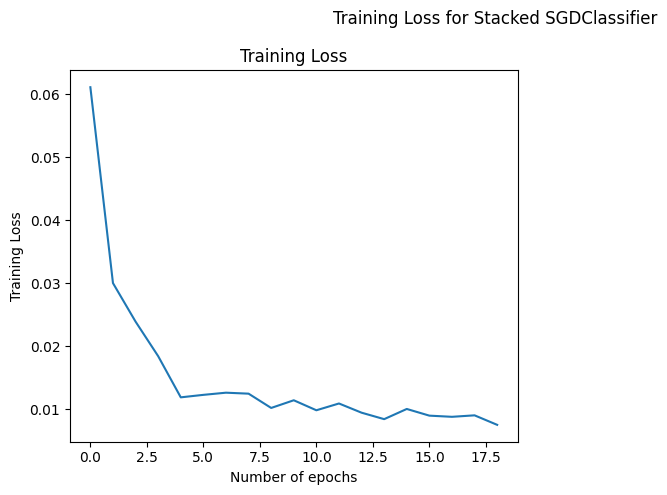

Shape of stackedX before reshaping: (963, 2, 3)
Shape of stackedX after reshaping: (963, 6)
Stacked Test Accuracy: 0.972


NameError: name 'evaluate_model' is not defined

In [9]:
import os
from keras.models import load_model
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

import sys
import numpy as np
from io import StringIO
import matplotlib.pyplot as plt

import os

def load_all_models(i=0):
    all_models = list()

    folder_path = 'F://Development_//Deep Learning//Basic Dataset//BTP//1//Outputs//Models//LSTM//word2vec//part2'
    if i == 0:
        model_files = [f for f in os.listdir(folder_path) if f.endswith('w2v_150.keras')]
    else:
        model_files = [f for f in os.listdir(folder_path) if f.endswith('ft_150.keras')]
    
    for filename in model_files:
        model_path = os.path.join(folder_path, filename)
        model = load_model(model_path)
        all_models.append(model)
        print(f'> Loaded {model_path}')

    return all_models


from sklearn.linear_model import SGDClassifier

def stacked_dataset(members, inputX):
    stackX = None
    for model in members:
        # make prediction
        yhat = model.predict(inputX, verbose=0)
        # stack predictions into [rows, members, probabilities]
        if stackX is None:
            stackX = yhat
        else:
            stackX = dstack((stackX, yhat))
    # flatten predictions to [rows, members x probabilities]
    print("Shape of stackedX before reshaping:", stackX.shape)
    stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
    print("Shape of stackedX after reshaping:", stackX.shape)
    return stackX

def fit_stacked_model(members, inputX, inputy):
    # create dataset using ensemble stackedX
    stackedX = stacked_dataset(members, inputX)

    # Capture model output
    old_stdout = sys.stdout
    sys.stdout = mystdout = StringIO()

    # Fit SGDClassifier model
    model = SGDClassifier(verbose=1)  # Set verbose=1 to print training metrics
    model.fit(stackedX, inputy)

    # Restore standard output
    sys.stdout = old_stdout

    # Extract loss history
    loss_history = mystdout.getvalue()
    loss_list = [float(line.split("loss: ")[-1]) for line in loss_history.split('\n') if "loss: " in line]

    # Extract accuracy history (assuming model reports accuracy during training)
    accuracy_list = [float(line.split("accuracy: ")[-1]) for line in loss_history.split('\n') if "accuracy: " in line]

    # Plot loss and accuracy
    plt.figure(figsize=(10, 5))  # Adjust figure size for two plots

    # Loss plot
    plt.subplot(1, 2, 1)  # Create first subplot for loss
    plt.plot(np.arange(len(loss_list)), loss_list)
    plt.xlabel("Number of epochs")
    plt.ylabel("Training Loss")
    plt.title("Training Loss")
    plt.suptitle("Training Loss for Stacked SGDClassifier")  # Add overall title
    plt.tight_layout()  # Adjust spacing between plots
    plt.show()

    return model

# make a prediction with the stacked model
def stacked_prediction(members, model, inputX):
    # create dataset using ensemble
    stackedX = stacked_dataset(members, inputX)
    # make a prediction
    yhat = model.predict(stackedX)
    return yhat

X_train, X_test, y_train, y_test, test_codes = load_data()

print('Model Accuracy:')
# Tokenize the sequences
X_train_padded, X_test_padded, test_padded, word_index = tokenize_sequences(X_train, X_test, test_codes)

import itertools

members = load_all_models(1)
# for model in members:
#    _, acc = model.evaluate(X_test_padded, y_test, verbose=0)
#    print('Model Accuracy: %.3f' % acc

# fit stacked model using the ensemble
model = fit_stacked_model(members, X_train_padded, y_train)

# evaluate model on test set
yhat = stacked_prediction(members, model, X_test_padded)
acc = accuracy_score(y_test, yhat)
print('Stacked Test Accuracy: %.3f' % acc)
evaluate_model(X_test_padded, y_test, model)


In [ ]:
import os
from keras.models import load_model
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

import sys
import numpy as np
from io import StringIO
import matplotlib.pyplot as plt

import os

def load_all_models(i=0):
    all_models = list()

    folder_path = '/home/shaurya/BTP/1/Outputs/Models/LSTM/word2vec'
    if i == 0:
        model_files = [f for f in os.listdir(folder_path) if f.endswith('w2v.keras')]
    else:
        model_files = [f for f in os.listdir(folder_path) if f.endswith('ft.keras')]
    
    for filename in model_files:
        model_path = os.path.join(folder_path, filename)
        model = load_model(model_path)
        all_models.append(model)
        print(f'> Loaded {model_path}')

    return all_models


from sklearn.linear_model import SGDClassifier

def stacked_dataset(members, inputX):
    stackX = None
    for model in members:
        # make prediction
        yhat = model.predict(inputX, verbose=0)
        # stack predictions into [rows, members, probabilities]
        if stackX is None:
            stackX = yhat
        else:
            stackX = dstack((stackX, yhat))
    # flatten predictions to [rows, members x probabilities]
    stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
    return stackX

def fit_stacked_model(members, inputX, inputy):
    # create dataset using ensemble stackedX
    stackedX = stacked_dataset(members, inputX)

    # Capture model output
    old_stdout = sys.stdout
    sys.stdout = mystdout = StringIO()

    # Fit SGDClassifier model
    model = SGDClassifier(verbose=1)  # Set verbose=1 to print training metrics
    model.fit(stackedX, inputy)

    # Restore standard output
    sys.stdout = old_stdout

    # Extract loss history
    loss_history = mystdout.getvalue()
    loss_list = [float(line.split("loss: ")[-1]) for line in loss_history.split('\n') if "loss: " in line]

    # Extract accuracy history (assuming model reports accuracy during training)
    accuracy_list = [float(line.split("accuracy: ")[-1]) for line in loss_history.split('\n') if "accuracy: " in line]

    # Plot loss and accuracy
    plt.figure(figsize=(10, 5))  # Adjust figure size for two plots

    # Loss plot
    plt.subplot(1, 2, 1)  # Create first subplot for loss
    plt.plot(np.arange(len(loss_list)), loss_list)
    plt.xlabel("Number of epochs")
    plt.ylabel("Training Loss")
    plt.title("Training Loss")
    plt.suptitle("Training Loss for Stacked SGDClassifier")  # Add overall title
    plt.tight_layout()  # Adjust spacing between plots
    plt.show()

    return model

# make a prediction with the stacked model
def stacked_prediction(members, model, inputX):
    # create dataset using ensemble
    stackedX = stacked_dataset(members, inputX)
    # make a prediction
    yhat = model.predict(stackedX)
    return yhat

X_train, X_test, y_train, y_test, test_codes = load_data()

print('Model Accuracy:')
# Tokenize the sequences
X_train_padded, X_test_padded, test_padded, word_index = tokenize_sequences(X_train, X_test, test_codes)

import itertools

members = load_all_models(1)
# for model in members:
#    _, acc = model.evaluate(X_test_padded, y_test, verbose=0)
#    print('Model Accuracy: %.3f' % acc)

# fit stacked model using the ensemble
model = fit_stacked_model(members, X_test_padded, y_test)

# evaluate model on test set
yhat = stacked_prediction(members, model, X_test_padded)
acc = accuracy_score(y_test, yhat)
print('Stacked Test Accuracy: %.3f' % acc)



Model Accuracy:


# Integerated

In [2]:
import os
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"
from keras.models import load_model
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input, Dense, concatenate
from numpy import argmax
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from numpy import dstack

import random
import string

def generate_random_name():
    return ''.join(random.choices(string.ascii_letters + string.digits, k=10))

def rename_nested_layers(model, filename, model_index):
    for layer in model.layers:
        original_name = layer.name
        random_name = f"{filename}_{model_index}_{generate_random_name()}"
        layer._name = random_name

        if hasattr(layer, 'layers'):  # Check for nested layers
            rename_nested_layers(layer, filename, model_index)  # Recursive call

# The rest of your code remains unchanged

def load_all_models():
    all_models = list()

    folder_path = '/home/shaurya/BTP/1/Outputs/finalBase'
    model_files = [f for f in os.listdir(folder_path) if f.endswith('.keras')]

    for model_index, filename in enumerate(model_files):
        model_path = os.path.join(folder_path, filename)
        model = load_model(model_path)

        # Rename all layers recursively
#         rename_nested_layers(model, filename, model_index)

        all_models.append(model)
        print(f'> Loaded {model_path}')

    return all_models

def define_stacked_model(members):
    # Update all layers in all models to not be trainable
    for i, model in enumerate(members):
        for layer in model.layers:
            # Make not trainable
            layer.trainable = False

    # Define multi-headed input 
    ensemble_visible = [model.input for model in members]

    # Concatenate merge output from each model
    ensemble_outputs = [model.output for model in members]
    merge = concatenate(ensemble_outputs)

    hidden = Dense(10, activation='relu')(merge)
    output = Dense(2, activation='softmax')(hidden)

    model = Model(inputs=ensemble_visible, outputs=output)

    # Plot graph of ensemble
#     plot_model(model, show_shapes=True, to_file='model_graph.png')

    # Compile
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

def fit_stacked_model(model, inputX, inputy):
    # prepare input data
    X = [inputX for _ in range(len(model.input))]
    
    # encode output data
    inputy_enc = to_categorical(inputy)
    
    # fit model
    model.fit(X, inputy_enc, epochs=300, verbose=0)

def predict_stacked_model(model, inputX):
    # prepare input data
    X = [inputX for _ in range(len(model.input))]
    
    # make prediction
    return model.predict(X, verbose=0)

X_train, X_test, y_train, y_test, test_codes = load_data()

# Tokenize the sequences
X_train_padded, X_test_padded, test_padded, word_index = tokenize_sequences(X_train, X_test, test_codes)

members = load_all_models()

# for model in members:
#     _, acc = model.evaluate(X_test_padded, y_test, verbose=0)
#     print('Model Accuracy: %.3f' % acc)

# define ensemble model
stacked_model = define_stacked_model(members)

# fit stacked model on test dataset
fit_stacked_model(stacked_model, X_test_padded, y_test)

# make predictions and evaluate
yhat = predict_stacked_model(stacked_model, X_test_padded)
yhat = argmax(yhat, axis=1)
acc = accuracy_score(y_test, yhat)
print('Stacked Test Accuracy: %.3f' % acc)


> Loaded /home/shaurya/BTP/1/Outputs/finalBase/LSTM_w2v.keras
> Loaded /home/shaurya/BTP/1/Outputs/finalBase/BLSTM_w2v.keras
> Loaded /home/shaurya/BTP/1/Outputs/finalBase/GRU_w2v.keras


2024-03-11 02:45:28.859539: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8907


Stacked Test Accuracy: 0.974


# WITH GRAPH

In [2]:
import os
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"
from keras.models import load_model
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input, Dense, concatenate
from numpy import argmax
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from numpy import dstack

import random
import string

def generate_random_name():
    return ''.join(random.choices(string.ascii_letters + string.digits, k=10))

def rename_nested_layers(model, filename, model_index):
    for layer in model.layers:
        original_name = layer.name
        random_name = f"{filename}_{model_index}_{generate_random_name()}"
        layer._name = random_name

        if hasattr(layer, 'layers'):  # Check for nested layers
            rename_nested_layers(layer, filename, model_index)  # Recursive call

# The rest of your code remains unchanged

def load_all_models():
    all_models = list()

    folder_path = '/home/shaurya/BTP/1/Outputs/finalBase'
    model_files = [f for f in os.listdir(folder_path) if f.endswith('.keras')]

    for model_index, filename in enumerate(model_files):
        model_path = os.path.join(folder_path, filename)
        model = load_model(model_path)

        # Rename all layers recursively
#         rename_nested_layers(model, filename, model_index)

        all_models.append(model)
        print(f'> Loaded {model_path}')

    return all_models

def define_stacked_model(members):
    # Update all layers in all models to not be trainable
    for i, model in enumerate(members):
        for layer in model.layers:
            # Make not trainable
            layer.trainable = False

    # Define multi-headed input 
    ensemble_visible = [model.input for model in members]

    # Concatenate merge output from each model
    ensemble_outputs = [model.output for model in members]
    merge = concatenate(ensemble_outputs)

    hidden = Dense(10, activation='relu')(merge)
    output = Dense(2, activation='softmax')(hidden)

    model = Model(inputs=ensemble_visible, outputs=output)

    # Plot graph of ensemble
    plot_model(model, show_shapes=True, to_file='model_graph.png')

    # Compile
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

def fit_stacked_model(model, inputX, inputy):
    # prepare input data
    X = [inputX for _ in range(len(model.input))]
    
    # encode output data
    inputy_enc = to_categorical(inputy)
    
    # fit model
    model.fit(X, inputy_enc, epochs=300, verbose=0)

def predict_stacked_model(model, inputX):
    # prepare input data
    X = [inputX for _ in range(len(model.input))]
    
    # make prediction
    return model.predict(X, verbose=0)

X_train, X_test, y_train, y_test, test_codes = load_data()

# Tokenize the sequences
X_train_padded, X_test_padded, test_padded, word_index = tokenize_sequences(X_train, X_test, test_codes)

members = load_all_models()

# for model in members:
#     _, acc = model.evaluate(X_test_padded, y_test, verbose=0)
#     print('Model Accuracy: %.3f' % acc)

# define ensemble model
stacked_model = define_stacked_model(members)

# fit stacked model on test dataset
fit_stacked_model(stacked_model, X_test_padded, y_test)

# make predictions and evaluate
yhat = predict_stacked_model(stacked_model, X_test_padded)
yhat = argmax(yhat, axis=1)
acc = accuracy_score(y_test, yhat)
print('Stacked Test Accuracy: %.3f' % acc)


> Loaded /home/shaurya/BTP/1/Outputs/finalBase/LSTM_w2v.keras
> Loaded /home/shaurya/BTP/1/Outputs/finalBase/BLSTM_w2v.keras
> Loaded /home/shaurya/BTP/1/Outputs/finalBase/GRU_w2v.keras
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


2024-03-11 04:04:02.187577: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8907


Stacked Test Accuracy: 0.975


In [7]:
import os
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"
from keras.models import load_model
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input, Dense, concatenate
from numpy import argmax
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from numpy import dstack

import random
import string

def generate_random_name():
    return ''.join(random.choices(string.ascii_letters + string.digits, k=10))

def rename_nested_layers(model, filename, model_index):
    for layer in model.layers:
        original_name = layer.name
        random_name = f"{filename}_{model_index}_{generate_random_name()}"
        layer._name = random_name

        if hasattr(layer, 'layers'):  # Check for nested layers
            rename_nested_layers(layer, filename, model_index)  # Recursive call

# The rest of your code remains unchanged

def load_all_models():
    all_models = list()

    folder_path = '/home/shaurya/BTP/1/Outputs/Models/LSTM/word2vec'
    model_files = [f for f in os.listdir(folder_path) if f.endswith('.keras')]

    for model_index, filename in enumerate(model_files):
        model_path = os.path.join(folder_path, filename)
        model = load_model(model_path)

        # Rename all layers recursively
#         rename_nested_layers(model, filename, model_index)

        all_models.append(model)
        print(f'> Loaded {model_path}')

    return all_models

def define_stacked_model(members):
    # Update all layers in all models to not be trainable
    for i, model in enumerate(members):
        for layer in model.layers:
            # Make not trainable
            layer.trainable = False

    # Define multi-headed input 
    ensemble_visible = [model.input for model in members]

    # Concatenate merge output from each model
    ensemble_outputs = [model.output for model in members]
    merge = concatenate(ensemble_outputs)

    hidden = Dense(10, activation='relu')(merge)
    output = Dense(1, activation='softmax')(hidden)

    model = Model(inputs=ensemble_visible, outputs=output)

    # Plot graph of ensemble
#     plot_model(model, show_shapes=True, to_file='model_graph.png')

    # Compile
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

def fit_stacked_model(model, inputX, inputy):
    # prepare input data
    X = [inputX for _ in range(len(model.input))]
    
    # encode output data
    inputy_enc = to_categorical(inputy)
    
    # fit model
    model.fit(X, inputy, epochs=300, verbose=0)

def predict_stacked_model(model, inputX):
    # prepare input data
    X = [inputX for _ in range(len(model.input))]
    
    # make prediction
    return model.predict(X, verbose=0)

X_train, X_test, y_train, y_test, test_codes = load_data()

# Tokenize the sequences
X_train_padded, X_test_padded, test_padded, word_index = tokenize_sequences(X_train, X_test, test_codes)

members = load_all_models()

# for model in members:
#     _, acc = model.evaluate(X_test_padded, y_test, verbose=0)
#     print('Model Accuracy: %.3f' % acc)

# define ensemble model
stacked_model = define_stacked_model(members)

# fit stacked model on test dataset
fit_stacked_model(stacked_model, X_test_padded, y_test)

# make predictions and evaluate
yhat = predict_stacked_model(stacked_model, X_test_padded)
yhat = argmax(yhat, axis=1)
acc = accuracy_score(y_test, yhat)
print('Stacked Test Accuracy: %.3f' % acc)


DEBUG:tensorflow:Layer GRU_W2V will use cuDNN kernels when running on GPU.
> Loaded /home/shaurya/BTP/Outputs/Models/LSTM/word2vec/GRU_w2v.keras
DEBUG:tensorflow:Layer lstm_2 will use cuDNN kernels when running on GPU.
DEBUG:tensorflow:Layer lstm_2 will use cuDNN kernels when running on GPU.
DEBUG:tensorflow:Layer lstm_2 will use cuDNN kernels when running on GPU.
DEBUG:tensorflow:Layer lstm_3 will use cuDNN kernels when running on GPU.
DEBUG:tensorflow:Layer lstm_3 will use cuDNN kernels when running on GPU.
DEBUG:tensorflow:Layer lstm_3 will use cuDNN kernels when running on GPU.
> Loaded /home/shaurya/BTP/Outputs/Models/LSTM/word2vec/BLSTM_w2v.keras
DEBUG:tensorflow:Layer LSTM_W2V_1 will use cuDNN kernels when running on GPU.
DEBUG:tensorflow:Layer LSTM_W2V_2 will use cuDNN kernels when running on GPU.
> Loaded /home/shaurya/BTP/Outputs/Models/LSTM/word2vec/LSTM_w2v.keras
DEBUG:tensorflow:Layer lstm will use cuDNN kernels when running on GPU.
DEBUG:tensorflow:Layer lstm will use cuD

In [3]:
def load_all_models():
    all_models = list()

    folder_path = '/home/shaurya/BTP/1/Outputs/Models/LSTM/word2vec'
    model_files = [f for f in os.listdir(folder_path) if f.endswith('.keras')]

    for model_index, filename in enumerate(model_files):
        model_path = os.path.join(folder_path, filename)
        model = load_model(model_path)

        # Rename all layers recursively
#         rename_nested_layers(model, filename, model_index)

        all_models.append(model)
        print(f'> Loaded {model_path}')

    return all_models

def list_models_and_layers(members):
    for i, model in enumerate(members):
        print(f"Model {i + 1}:")
        print_layer_names(model)
#         print(f"  Layers:")
#         for layer in model.layers:
#             print(f"    {layer.name}")
#         print("")

def print_layer_names(model, indent=0):
    for layer in model.layers:
        print(" " * indent + layer.name)
        if hasattr(layer, 'layers') and layer.layers:
            print_layer_names(layer, indent + 4)

# Assuming members is a list of loaded models
members = load_all_models()  # Replace with your actual loading mechanism
list_models_and_layers(members)


2024-01-24 10:22:33.316552: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-24 10:22:39.166754: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6748 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:1b:00.0, compute capability: 6.1
2024-01-24 10:22:39.167709: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 3946 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:1d:00.0, compute capability: 6.1
2024-01-24 10:22:39.168554: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:loc

DEBUG:tensorflow:Layer GRU_W2V will use cuDNN kernels when running on GPU.
> Loaded /home/shaurya/BTP/Outputs/Models/LSTM/word2vec/GRU_w2v.keras
DEBUG:tensorflow:Layer lstm_2 will use cuDNN kernels when running on GPU.
DEBUG:tensorflow:Layer lstm_2 will use cuDNN kernels when running on GPU.
DEBUG:tensorflow:Layer lstm_2 will use cuDNN kernels when running on GPU.
DEBUG:tensorflow:Layer lstm_3 will use cuDNN kernels when running on GPU.
DEBUG:tensorflow:Layer lstm_3 will use cuDNN kernels when running on GPU.
DEBUG:tensorflow:Layer lstm_3 will use cuDNN kernels when running on GPU.
> Loaded /home/shaurya/BTP/Outputs/Models/LSTM/word2vec/BLSTM_w2v.keras
DEBUG:tensorflow:Layer LSTM_W2V_1 will use cuDNN kernels when running on GPU.
DEBUG:tensorflow:Layer LSTM_W2V_2 will use cuDNN kernels when running on GPU.
> Loaded /home/shaurya/BTP/Outputs/Models/LSTM/word2vec/LSTM_w2v.keras
DEBUG:tensorflow:Layer lstm will use cuDNN kernels when running on GPU.
DEBUG:tensorflow:Layer lstm will use cuD